In [ ]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import pydmd
import os
from utils import *

In [3]:
def TDE_wravel(X: np.array, lag: int):
    T, N = X.shape
    X_delay = np.zeros((T-lag+1, N*lag), dtype = 'complex128')
    for l in range(lag):
        X_delay[:,l*N:(l+1)*N] = X[l:T-(lag-1)+l]
    
    return X_delay

def TDE_unwravel(X_delay: np.array, lag: int):
    T_all, N_all = X_delay.shape

    N = N_all // lag
    T = T_all+lag-1
    X = np.zeros((T, N),dtype = 'complex128')
    for t in range(T_all):
        for l in range(lag):
            X[t+l,:] = X_delay[t,l*N:(l+1)*N]
        
    return X

In [ ]:
tde_lag = 30   #lag for time delay embedding
scenario = 245 #ssp number (126, 245, 370, or 585)

member_num = 1 #ensemble member

data_path = '/home/nate/Documents/DMDc4Climate/data/train_val'
forcing_path = '/home/nate/Documents/DMDc4Climate/data/forcings'

In [ ]:
# load data

historical_path = os.path.join(data_path, 'outputs_historical.nc')
ssp_path = os.path.join(data_path, f'outputs_ssp{scenario}.nc')

xr_hist_clim = xr.open_dataset(historical_path).sel(member = member_num)
xr_ssp_clim = xr.open_dataset(ssp_path).sel(member = member_num)

all_data = xr.concat([xr_hist_clim, xr_ssp_clim], dim = 'time')

tas_all = all_data.tas.values
times = all_data.time
lat_data = all_data.lat.values
lon_data = all_data.lon.values

ntime, nlat, nlong = tas_all.shape

tas_data = tas_all.reshape(ntime, -1)[tde_lag-1:,:].T

In [6]:
# a small change to plotting function
plotmap = lambda mode, ax, amax: make_plot(mode, lat_data, lon_data, fig, ax, mode_num=0,
                                           min_val=-amax, max_val=amax, colorbar=True)

In [ ]:
# load forcing data

forcing_data_raw = np.load(os.path.join(forcing_path, f'historical+ssp{scenario}_forcing.npy')).T
forcing_data = TDE_wravel(forcing_data_raw, lag = tde_lag)[:-1,:].T

In [ ]:
# fit dmdc
my_dmdc = pydmd.DMDc(svd_rank=5) 
my_dmdc.fit(tas_data, forcing_data)

Text(0.5, 1.0, 'SSP245')

<Figure size 640x480 with 0 Axes>

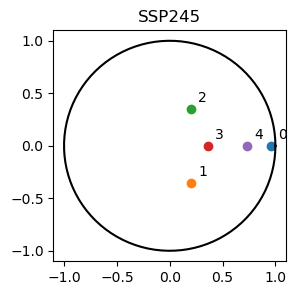

In [ ]:
# plot dmdc eigs
plt.figure()
theta = np.linspace(0, 2*np.pi, 100)
x = np.cos(theta)
y = np.sin(theta)
plt.figure(figsize=(3, 3))
plt.plot(x, y, color = 'k')
for i, eig in enumerate(my_dmdc.eigs):
    plt.scatter(np.real(eig), np.imag(eig))
    plt.annotate(str(i), (np.real(eig), np.imag(eig)), 
                xytext=(5, 5), textcoords='offset points')
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
plt.title(f'SSP{scenario}')

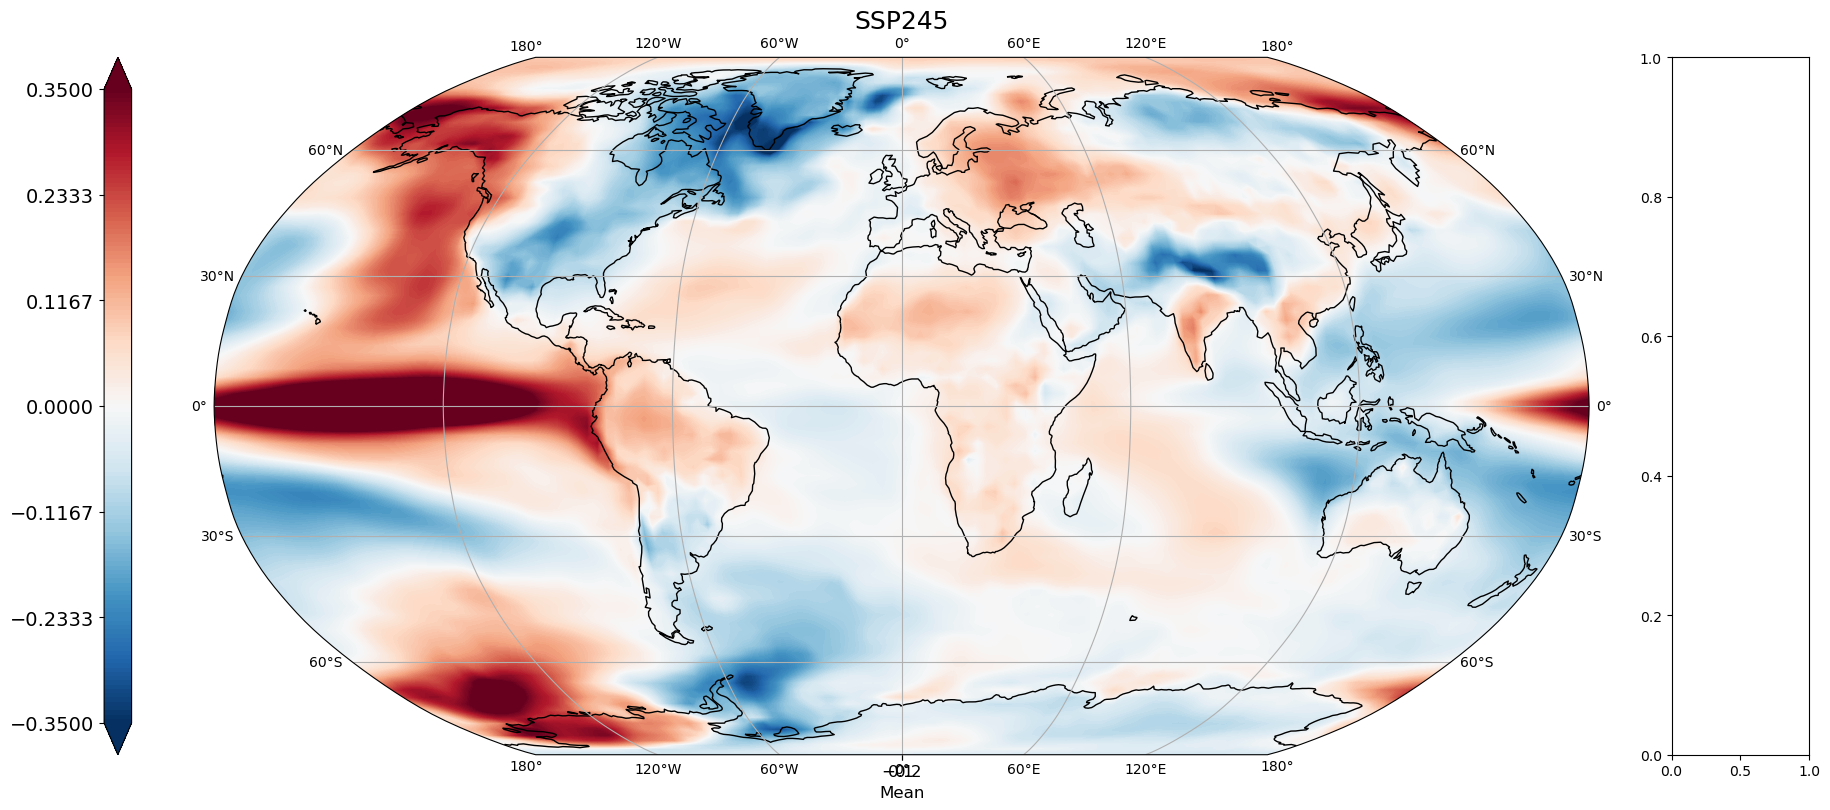

In [ ]:
# plot autoregressive component

fig, ax = plt.subplots(1, 1, figsize=(18,8), 
                       subplot_kw={'projection': ccrs.Robinson()})

ax.inset_axes((1.06, 0, 0.1, 1))

mapping = {245: [1,2]}
colors = ['tab:blue','tab:orange','tab:green','tab:red'] 
i=0

dmd = my_dmdc
X0 = 2*np.real(dmd.modes[:,mapping[scenario][0]]*dmd.amplitudes[mapping[scenario][0]]) 
ax.plot(np.mean(np.real(X0).reshape(96, 144), axis = 1), lat_data, color = colors[i], alpha = 1, lw = 2)
ax.set_yticks([])
ax.set_xlim([-.25,.12])
ax.set_xticks([-.2,.1])
ax.set_xlabel('Mean',fontsize=12)
ax.tick_params(axis='x',labelsize=12)


X0 = 2*np.real(my_dmdc.modes[:,mapping[scenario][0]]*my_dmdc.amplitudes[mapping[scenario][0]]) 
plotmap(X0, ax, .35) #did not use max val here because the max val is >1 and washes out the color
ax.set_title(f"SSP{scenario}", fontdict = {'fontsize':18})


plt.tight_layout()

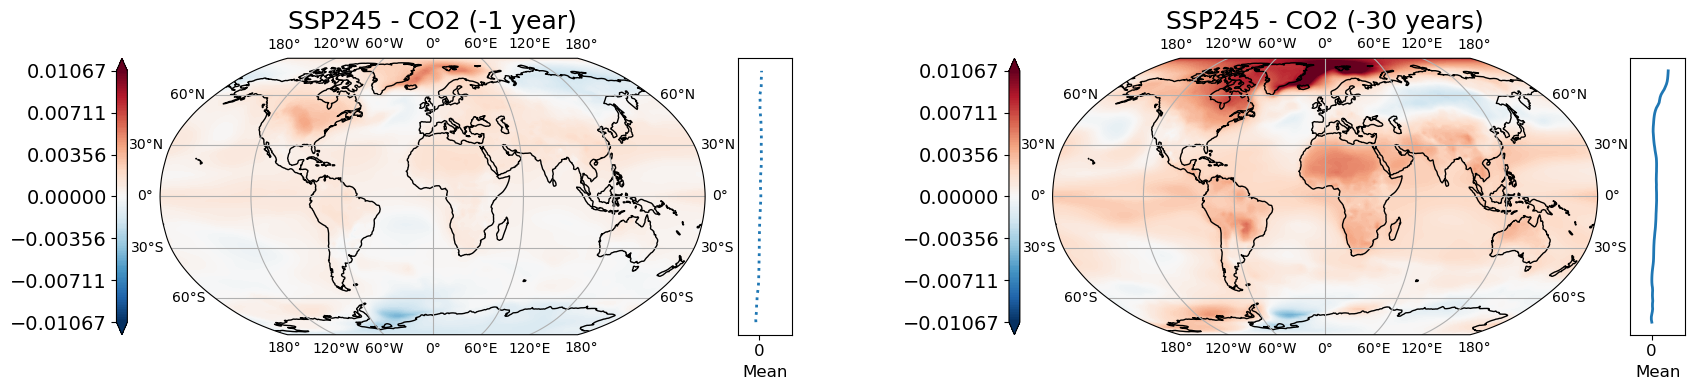

In [ ]:
# plot CO2 part of the emissions contribution

fig, ax = plt.subplots(1, 2, figsize=(18, 4), subplot_kw={'projection': ccrs.Robinson()})

caxs = []
for axi in ax.flatten():
    caxs.append(axi.inset_axes((1.06, 0, 0.1, 1)))

CO2_idx_m1 = np.arange(0,tde_lag*4,4)[[0]]
CO2_idx_m30 = np.arange(0,tde_lag*4,4)[[-1]]

amax = np.max([np.real(np.mean(my_dmdc.B[:, CO2_idx_m30]@ forcing_data[CO2_idx_m30,:], axis = 1)).max(),-np.real(np.mean(my_dmdc.B[:, CO2_idx_m30]@ forcing_data[CO2_idx_m30,:], axis = 1)).min()])

X_co2 = np.real(np.mean(my_dmdc.B[:, CO2_idx_m1]@ forcing_data[CO2_idx_m1,:], axis = 1))
plotmap(X_co2, ax[0], amax-.005)
ax[0].set_title(f"SSP{scenario} - CO2 (-1 year)",
                   fontdict = {'fontsize':18})

X1_co2 = np.real(np.mean(my_dmdc.B[:, CO2_idx_m30]@ forcing_data[CO2_idx_m30,:], axis = 1))
plotmap(X1_co2, ax[1], amax-.005)
ax[1].set_title(f"SSP{scenario} - CO2 (-30 years)",
                   fontdict = {'fontsize':18})

linestyles = ['dotted', 'solid']
for i in range(2):
    for j, X0 in enumerate([X_co2, X1_co2]):
        if i == j:
            a = 1
        else:
            a = 0
        caxs[i].plot(np.mean(X0.reshape(96, 144), axis = 1), lat_data, color = 'tab:blue', alpha = a, lw = 2, linestyle = linestyles[j])
        caxs[i].set_yticks([])
        caxs[i].set_xlim([-.01,amax])
        caxs[j].set_xticks([0])
        caxs[j].set_xlabel('Mean',fontsize=12)
        caxs[j].tick_params(axis='x',labelsize=12)

    plt.tight_layout()